In [1]:
# Installs PyTorch with CUDA 12.6 support
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {DEVICE}")

Running on device: cuda:0


_______________________________________________________________________________________________________________________________________________________________________________

# DCGAN

### Importing libraries

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [5]:
import numpy as np
import datetime
import os,sys
import glob

In [6]:
from PIL import Image

### Transorms

1. Resize Images to 64x64
2.We are converting pixel values from [0.0,1.0] (ToTensor) to [-1,1] (Normalizing for RGB)

In [7]:
Img_Dim = (64,64,3)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
])

Dataset (tiny-imagenet)

In [8]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from datasets import load_dataset

c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ds = load_dataset("zh-plus/tiny-imagenet",split="train")
print(ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 100000
})


### Dataset Wrapper 

It changes Huggingface style object (dictionary) to torch.Tensor (shape = [3,64,64])

In [11]:
class dataset_wrap(torch.utils.data.Dataset):
  def __init__(self,ds,transform = None):
    self.ds =ds
    self.transform = transform

  def __len__(self):
    return len(self.ds)
  def __getitem__(self,indx):
    item = self.ds[indx]
    img = item['image'].convert('RGB') # Changed 'item' to 'image'
    if self.transform:
      img = self.transform(img)
    return img
  
dataset = dataset_wrap(ds,transform=transform)


In [12]:
data_loader = DataLoader(
  dataset=dataset,
    batch_size=64, 
    shuffle=True,
    num_workers=0
)

Testing 1 batch 

In [13]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Batch shape: torch.Size([64, 3, 64, 64])


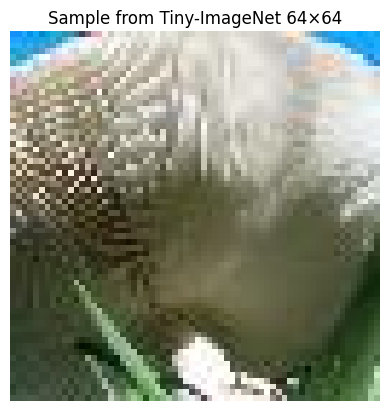

In [14]:
import matplotlib.pyplot as plt
real_images = next(iter(data_loader))
print("Batch shape:", real_images.shape)
import matplotlib.pyplot as plt
img = real_images[0].permute(1,2,0).cpu().numpy()
img = (img * 0.5) + 0.5
plt.imshow(img)
plt.axis('off')
plt.title("Sample from Tiny-ImageNet 64×64")
plt.show()

### Residual Block

In [15]:
class ResidualBlock(nn.Module):
  def __init__ (self,channels):
    super(ResidualBlock,self).__init__()
    self.conv1 = nn.Conv2d(channels, channels , kernel_size =3 , stride = 1 , padding = 1 , bias =  False)
    self.bn1 = nn.BatchNorm2d(channels)
    self.conv2 = nn.Conv2d(channels , channels, kernel_size=3 , stride=1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(channels)

  def forward(self,x):
    resi = x
    out = f.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += resi
    return f.relu(out)

### Discriminator

In [16]:
class Discriminator(nn.Module):
  def __init__ (self,in_channel = 3):
    super(Discriminator,self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channel, 512 , kernel_size =4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True)
    )
    self.res1 = ResidualBlock(512)
    self.conv2 = nn.Sequential(
        nn.Conv2d(512,256, kernel_size =4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True)
    )
    self.res2 = ResidualBlock(256)

    self.conv3 = nn.Sequential(
        nn.Conv2d(256,128, kernel_size =4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True)
    )
    self.res3 = ResidualBlock(128)

    self.con4 = nn.Sequential(
        nn.Conv2d(128,128, kernel_size =4, stride = 2, padding=1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True)
    )
    self.res4 = ResidualBlock(128)

    self.pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Sequential(
        nn.Linear(128,1),
        nn.Sigmoid(),
    )

  def forward(self,x):
    x= self.conv1(x)
    x = self.res1(x)
    x= self.conv2(x)
    x = self.res2(x)
    x= self.conv3(x)
    x = self.res3(x)
    x= self.con4(x)
    x = self.res4(x)
    x= self.pool(x)

    x =x.view(x.size(0),-1)
    x = self.fc(x)
    return x

### Generator

In [17]:
class Generator(nn.Module):
  def __init__ (self, n_noise = 100 , out_channel = 3):
    super(Generator,self).__init__()

    self.init_dim = 4
    self.fc = nn.Sequential(
        nn.Linear(n_noise , 512* (self.init_dim **2)),
        nn.ReLU(inplace=True)
    )

    self.g1 = nn.Sequential(
        nn.ConvTranspose2d(512,256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True)
    )

    self.res1 = ResidualBlock(256)

    self.g2 = nn.Sequential(
        nn.ConvTranspose2d(256,128, kernel_size=4,stride =2, padding =1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
    )

    self.res2 = ResidualBlock(128)

    self.g3 = nn.Sequential(
        nn.ConvTranspose2d(128,128, kernel_size=4, stride =2, padding = 1,bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True)
    )
    self.res3 = ResidualBlock(128)

    self.g4 = nn.Sequential(
        nn.ConvTranspose2d(128,out_channel, kernel_size =4,stride=2, padding = 1, bias = False ),
        nn.Tanh()
    )

  def forward(self,x):
    x =  self.fc(x)
    x = x.view(x.size(0),512, self.init_dim, self.init_dim)

    x = self.g1(x)
    x = self.res1(x)
    x = self.g2(x)
    x = self.res2(x)
    x = self.g3(x)
    x = self.res3(x)
    x = self.g4(x)
    return x

### Testing 

In [18]:
# Instantiate
D = Discriminator().to(DEVICE)
G = Generator(n_noise=100).to(DEVICE)

# Shape check
z = torch.randn(2, 100).to(DEVICE)
fake = G(z)
print("G output:", fake.shape)  # [2, 3, 64, 64]

real = torch.randn(2, 3, 64, 64).to(DEVICE)
d_out = D(real)
print("D output:", d_out.shape)  # [2, 1]

G output: torch.Size([2, 3, 64, 64])
D output: torch.Size([2, 1])


In [19]:
def get_sample_image(G, n_noise):
    z = torch.randn(10, n_noise).to(DEVICE)
    y_hat = G(z).view(10, Img_Dim[2], Img_Dim[0], Img_Dim[1]).permute(0, 2, 3, 1)
    result = (y_hat.detach().cpu().numpy() + 1) / 2.
    return result

### Training 

In [20]:
!mkdir -p samples_DCGAN_res

In [21]:
# Fetch a single batch of real images
real_batch = next(iter(data_loader))

print(f"Min Pixel Value: {real_batch.min()}")
print(f"Max Pixel Value: {real_batch.max()}")
print(f"Mean Pixel Value: {real_batch.mean()}")


Min Pixel Value: -1.0
Max Pixel Value: 1.0
Mean Pixel Value: -0.12981556355953217


In [22]:
import torch
import torch.nn as nn
import os
import datetime
import matplotlib.pyplot as plt


max_epoch = 25
n_noise = 100
batch_size = 64
n_critic = 1
IMAGE_DIM = (64, 64, 3) 

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initializing weights acc to official DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



if 'G' in locals() and 'D' in locals():
    G.apply(weights_init)
    D.apply(weights_init)
    print("Weights initialized successfully.")

# Optimizers and loss function 
criterion = nn.BCELoss()

D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training 
print("Starting Training Loop...")
step = 0
noise_factor = 0.1  # Initial noise level 

for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        current_batch_size = images.size(0)

        # Label Smoothing: Real = 0.9 
        D_labels_real = torch.full((current_batch_size, 1), 0.9, device=DEVICE)
        D_fakes_zero = torch.zeros(current_batch_size, 1, device=DEVICE)

        # Training Discriminator
        D_opt.zero_grad()
        
        # Real Data Training 
        real_images = images.to(DEVICE)
        
        # Add noise to real images to blind the discriminator
        noise = torch.randn_like(real_images) * noise_factor
        real_noisy = real_images + noise
        real_noisy = torch.clamp(real_noisy, -1.0, 1.0) # Ensure valid range [-1, 1]
        
        x_outputs = D(real_noisy)
        D_x_loss = criterion(x_outputs, D_labels_real)

        # Fake Data Training
        z = torch.randn(current_batch_size, n_noise, device=DEVICE)
        fake = G(z)
        z_outputs = D(fake.detach()) # Detach to stop gradients to G
        D_z_loss = criterion(z_outputs, D_fakes_zero)

        D_loss = D_x_loss + D_z_loss
        D_loss.backward()
        D_opt.step()

        # Training Generator 
        if step % n_critic == 0:
            G_opt.zero_grad()
            
            # Generate fresh noise for G update
            z = torch.randn(current_batch_size, n_noise, device=DEVICE)
            fake = G(z)
            z_outputs = D(fake)
            
            G_labels_target = torch.ones(current_batch_size, 1, device=DEVICE) 
            G_loss = criterion(z_outputs, G_labels_target)

            G_loss.backward()
            G_opt.step()

        # Logging and sampling
        if step % 200 == 0:
            dt = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print(f'Epoch: {epoch+1}/{max_epoch}, Step: {step}, '
                  f'D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}, '
                  f'Noise Factor: {noise_factor:.4f}, Time: {dt}')

            # Save sample images
            G.eval()
            with torch.no_grad():
                # Assuming get_sample_image is your helper function
                if 'get_sample_image' in locals():
                    samples_DCGAN_res = get_sample_image(G, n_noise)
                    if not os.path.exists('samples_DCGAN_res'):
                        os.makedirs('samples_DCGAN_res')
                    
                    
                    plt.imsave(f'samples_DCGAN_res/resdcgan_epoch{epoch+1}_step{step:05d}.jpg', samples_DCGAN_res[0])
            G.train()

        step += 1
    
   
    # Decay noise factor 
    if noise_factor > 0.01:
        noise_factor *= 0.90
    print(f"End of Epoch {epoch+1}. New Noise Factor: {noise_factor:.4f}")

print("Training finished.")

Weights initialized successfully.
Starting Training Loop...
Epoch: 1/25, Step: 0, D Loss: 1.3916, G Loss: 0.7301, Noise Factor: 0.1000, Time: 2026-01-24 15:48:42
Epoch: 1/25, Step: 200, D Loss: 0.7246, G Loss: 1.9424, Noise Factor: 0.1000, Time: 2026-01-24 15:51:24
Epoch: 1/25, Step: 400, D Loss: 0.8164, G Loss: 2.1034, Noise Factor: 0.1000, Time: 2026-01-24 15:54:07
Epoch: 1/25, Step: 600, D Loss: 0.7677, G Loss: 2.5463, Noise Factor: 0.1000, Time: 2026-01-24 15:56:49
Epoch: 1/25, Step: 800, D Loss: 0.5025, G Loss: 2.8502, Noise Factor: 0.1000, Time: 2026-01-24 15:59:32
Epoch: 1/25, Step: 1000, D Loss: 0.5818, G Loss: 2.7880, Noise Factor: 0.1000, Time: 2026-01-24 16:02:15
Epoch: 1/25, Step: 1200, D Loss: 0.8634, G Loss: 3.1566, Noise Factor: 0.1000, Time: 2026-01-24 16:04:57
Epoch: 1/25, Step: 1400, D Loss: 0.9415, G Loss: 2.7265, Noise Factor: 0.1000, Time: 2026-01-24 16:07:40
End of Epoch 1. New Noise Factor: 0.0900
Epoch: 2/25, Step: 1600, D Loss: 0.9307, G Loss: 3.2723, Noise Fac

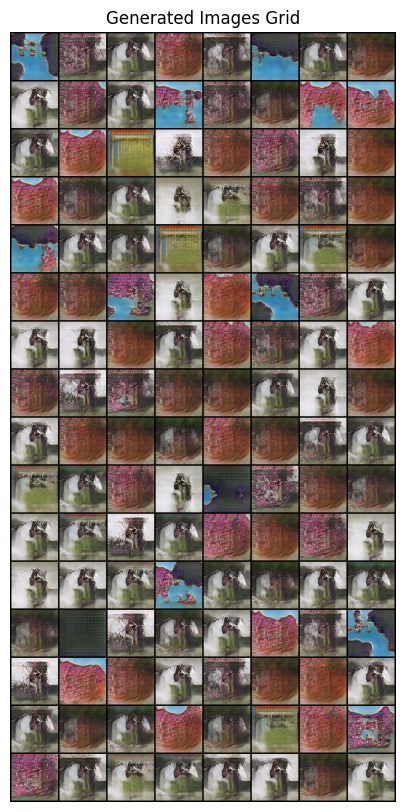

In [25]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

def visualize_generated_images(generator, n_noise, num_images=64, device=None):
    """
    Generates and displays a grid of images from the trained Generator.
    
    Args:
        generator: The trained Generator model.
        n_noise: The dimension of the input noise vector (e.g., 100).
        num_images: Number of images to display in the grid (default 64).
        device: The torch device (cuda or cpu).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Set to evaluation mode
    generator.eval()
    
    # 2. Generate noise
    # We generate 'num_images' random vectors
    z = torch.randn(num_images, n_noise, device=device)
    
    # 3. Generate fake images
    with torch.no_grad():
        fake_images = generator(z).detach().cpu()
    
    # 4. Create a grid using torchvision
    # padding=2 gives a small border between images
    grid = vutils.make_grid(fake_images, padding=2, normalize=True)
    
    # 5. Plotting
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Images Grid")
    
    # Transpose the grid from (C, H, W) to (H, W, C) for matplotlib
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

    # Reset to training mode if you plan to continue training
    generator.train()

# Run the visualization
# Ensure 'G' and 'n_noise' match your notebook variables
visualize_generated_images(G, n_noise=100, num_images=128, device=DEVICE)